In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import sys
sys.path.insert(1, '../../../utils/')
import src_utils
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scipy

# 1. Set rcParams

In [177]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['axes.linewidth'] = 0.5

plt.rcParams["figure.dpi"] = 300

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# 2. Set up grid

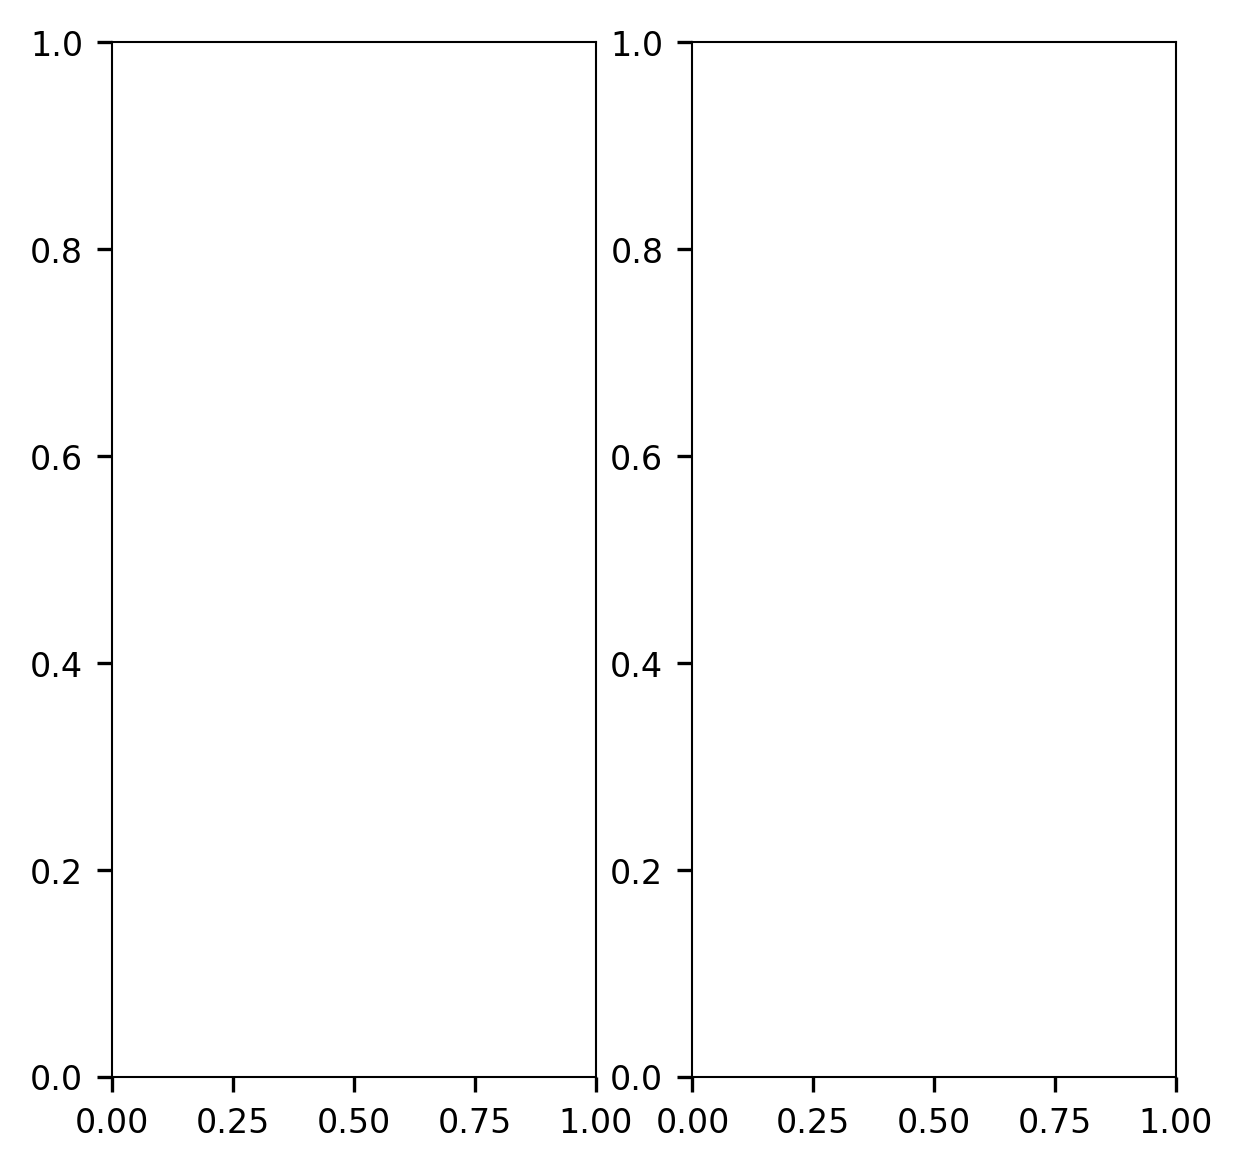

In [178]:
width = 114 / 25.4
height = 116 / 25.4
fig4 = plt.figure(constrained_layout=False, figsize=(width, height))
gs2 = fig4.add_gridspec(1, 2, left=0.16, right=0.95)

f4_ax3 = fig4.add_subplot(gs2[0, 0])
f4_ax4 = fig4.add_subplot(gs2[0, 1])


# Read in necessary data

In [179]:
# All residual values
resid_map = pd.read_csv('../../heatmaps/raw_resid_heatmap.csv', index_col=0)

# Client masks
client_mask = np.loadtxt('../../../utils/analysis_utils/client_mask.csv').astype(bool)
strong_client_mask = np.loadtxt('../../../utils/analysis_utils/strong_client_mask.csv').astype(bool)
ihb_client_mask = np.loadtxt('../../../utils/analysis_utils/inhibited_clients.csv').astype(bool)
dep_client_mask = np.loadtxt('../../../utils/analysis_utils/dependent_clients.csv').astype(bool)

# A. Windowed average

In [180]:
# Calculate moving average of client scores
def moving_average(a, n=10) :
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

pos_resid_ave = resid_map.mean(axis=1, skipna=True).values
windowed_resids = moving_average(pos_resid_ave)

# B. Inhibited vs dependent clients by position

In [181]:
# Get number of inhibited and dependent
num_dep = np.sum(dep_client_mask * 1, axis=1)
num_ihb = np.sum(ihb_client_mask * 1, axis=1)
num_mut = np.sum(~np.isnan(resid_map.values), axis=1)

# Calculate percentage
perc_dep = 100 * (num_dep / num_mut)
perc_ihb = 100 * (num_ihb / num_mut)

cmap = matplotlib.cm.get_cmap('bwr')
dep = cmap(0.3)
ihb = cmap(0.8)

pos_arr = np.arange(270, 520)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


# D. Difference from median score

In [182]:
# Types of mutants in clients
client_med_aa = np.nanmedian(resid_map.values, axis=0)

# Dictionary for ticks
inv_aa_idx_dict = {v: k for k, v in src_utils.__aa_idx_dict__.items()}

# Set tick labels and locations
y_pos = list(inv_aa_idx_dict.keys())
tick_labels = inv_aa_idx_dict.values()

# Plot bars
f4_ax3.barh(y_pos[:-1], client_med_aa[:-1], align='center', color='lightgrey')
f4_ax3.axvline(0, c='k')

# Relabel ticks
f4_ax3.set_yticks(y_pos[:-1])
f4_ax3.set_yticklabels(list(tick_labels)[:-1])
f4_ax3.set_xticks([-0.046, 0, 0.046])
f4_ax3.set_xticklabels([-0.03, 0, 0.03])
f4_ax3.invert_yaxis()  # labels read top-to-bottom

# Label axes
f4_ax3.set_xlabel('Median client score')
f4_ax3.set_ylabel('Amino acid')

Text(13.333333333333318, 0.5, 'Amino acid')

In [183]:
# Permutation test
from numpy.random import shuffle

num_muts = np.sum(~np.isnan(resid_map.values), axis=0)
num_dep = np.sum(dep_client_mask * 1, axis=0)
num_ihb = np.sum(ihb_client_mask * 1, axis=0)

t = abs(num_ihb - num_dep)

dep_copy = dep_client_mask.copy()
ihb_copy = ihb_client_mask.copy()

n_iter = 100000
results = np.zeros((21, n_iter))
for idx in np.arange(n_iter):
    # Flatten both
    dep_copy = dep_copy.flatten()
    ihb_copy = ihb_copy.flatten()
    
    # Shuffle as a 1D array
    shuffle(dep_copy)
    shuffle(ihb_copy)
    
    # Reshape into the right shape
    dep_copy = np.reshape(dep_copy, (250, 21))
    ihb_copy = np.reshape(ihb_copy, (250, 21))
    
    num_dep = np.sum(dep_copy * 1, axis=0)
    num_ihb = np.sum(ihb_copy * 1, axis=0)
    
    #perc_dep = 100 * (num_dep / num_muts)
    #perc_ihb = 100 * (num_ihb / num_muts)
    
    results[:, idx] = abs(num_ihb - num_dep)

# Calculate how many are above the threshold
n_over_t = np.zeros(21)

for idx in np.arange(len(n_over_t)):
    
    row = results[idx, :]
    count = sum(row > t[idx])
    n_over_t[idx] = count
    
n_over_t = (1.0 * n_over_t) / (1.0 * n_iter)

alpha = 0.05
sig_aas = n_over_t < alpha

pos = []
for idx, sig in enumerate(sig_aas):
    if sig:
        pos.append(idx)

In [184]:
# 0. Put p-values and AAs in DataFrame
p_vals = pd.DataFrame(n_over_t, index=tick_labels, columns=['p-value'])

# 1. Sort to ascending order
p_vals.sort_values(by='p-value', inplace=True)

# 2. Assign ranks
p_vals['rank'] = np.arange(1, len(p_vals) + 1)

# 3. Calculate critical B-H value
fdr_rate = 0.1
q_vals = []
n_tests = len(p_vals)
pos = []
for aa in p_vals.index.tolist():
    
    # Grab p-value and rank
    p_val = p_vals.loc[aa, 'p-value']
    rank = p_vals.loc[aa, 'rank']
    
    # Calculate critical B-H value
    q_val = (rank / n_tests) * fdr_rate
    
    # Append to list of q-values
    q_vals.append(q_val)
    
    # Save AA if p-value < q-value:
    if p_val < q_val:
        pos.append(aa)

# Append q-values to DataFrame
p_vals['q-value'] = q_vals

pos = [src_utils.__aa_idx_dict__[aa] for aa in pos]
pos

[17]

In [185]:
p_vals

,p-value,rank,q-value
Y,0.00340,1,0.004762
F,0.02875,2,0.009524
Q,0.04636,3,0.014286
I,0.07025,4,0.019048
R,0.07339,5,0.023810
K,0.15567,6,0.028571
S,0.15613,7,0.033333
V,0.15629,8,0.038095
W,0.21735,9,0.042857
A,0.21925,10,0.047619


In [186]:
# Plot percent of amino acid mutations that are clients
ax = f4_ax4
num_muts = np.sum(~np.isnan(resid_map.values), axis=0)
num_dep = np.sum(dep_client_mask * 1, axis=0)
num_ihb = np.sum(ihb_client_mask * 1, axis=0)

perc_dep = 100 * (num_dep / num_muts)
perc_ihb = 100 * (num_ihb / num_muts)

# set height of bar
diff = perc_ihb - perc_dep

# Set bar width
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(y_pos[:-1]))
r2 = [x + barWidth for x in r1]

# Set color
color_bars = []
for val in diff:
    if val > 0:
        color_bars.append(ihb)
    else:
        color_bars.append(dep)

# Plot bars
#fig, ax = plt.subplots()
ax.barh(r1, perc_dep[:-1], height=barWidth, color=dep)
ax.barh(r2, perc_ihb[:-1], height=barWidth, color=ihb)
#ax.barh(y_pos[:-1], perc_ihb[:-1], left=perc_dep[:-1], color=ihb)
#ax.axvline(0, c='k')
 

# Relabel ticks
ax.set_yticks(y_pos[:-1])
ax.set_yticklabels(list(tick_labels)[:-1])
ax.invert_yaxis()  # labels read top-to-bottom

#ax.set_xlim([-9, 9])

# Label axes
ax.set_xlabel('Percent client variants') 

ax.scatter([17.5] * len(pos), pos, marker=(6, 2, 0), c='k', linewidth=1)

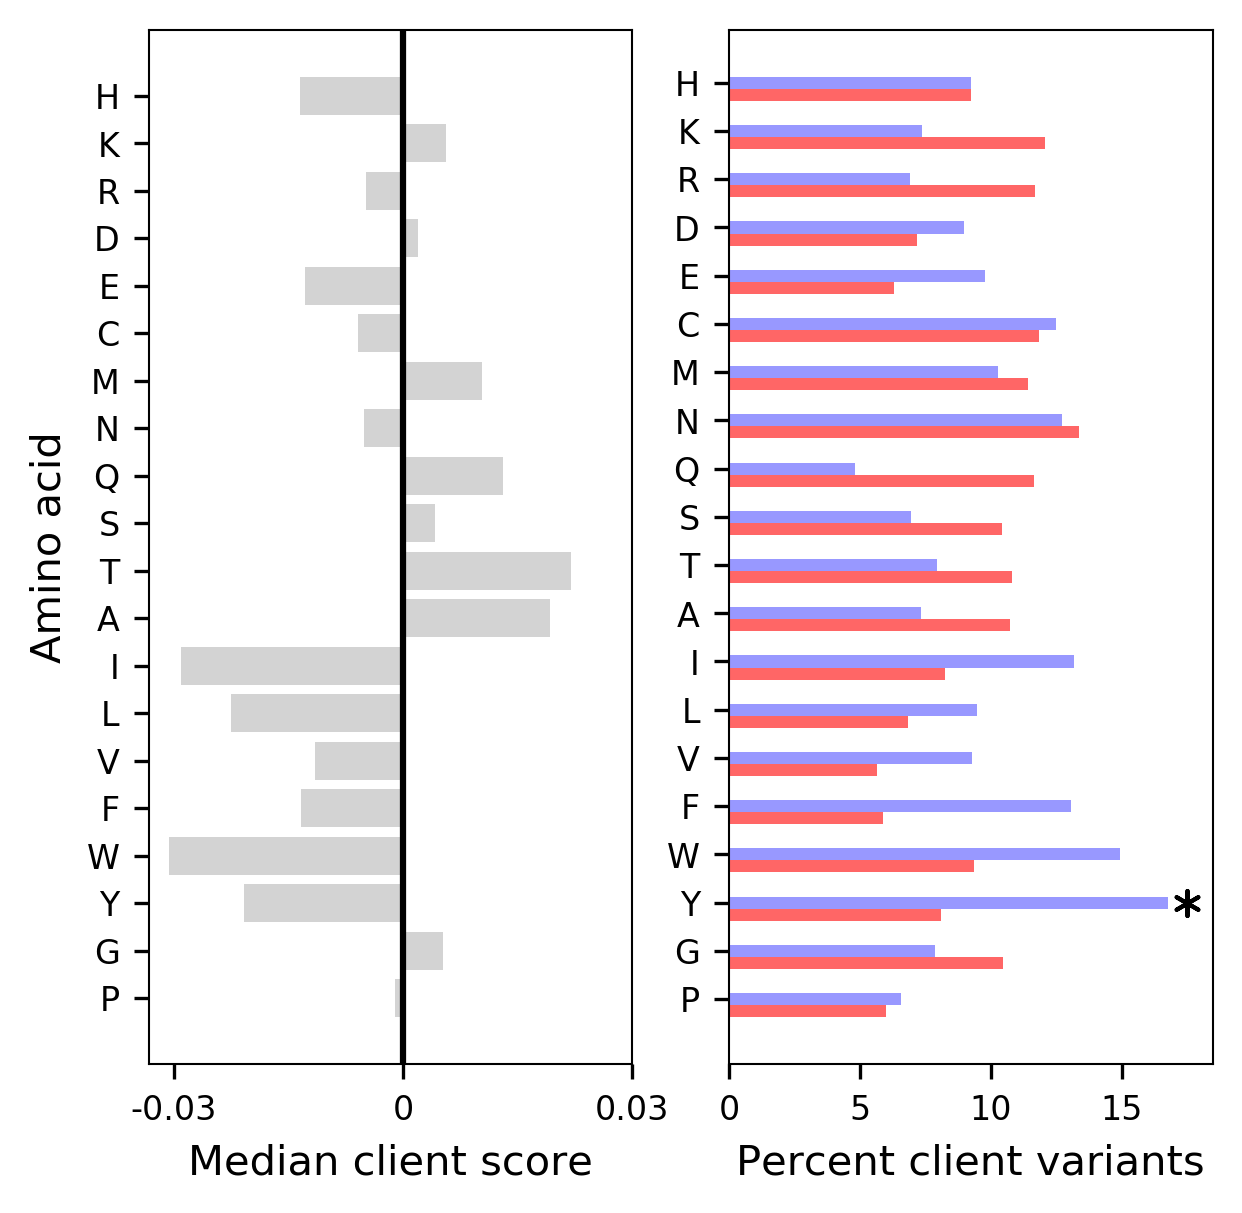

In [187]:
fig4

In [188]:
fig4.savefig('../../../Figures/manuscript_figs/fig4_drafts/f4_v4.png')

# Supplemental figure (aggregating by aa type)

In [154]:
# Aggregate by amino acid type
def agg_mask_map(mask):
    """
    Aggregate map by (position x aa) by aa types: positive,
    negative, polar, aliphatic, aromatic, misc (C, P, G).

    Args:
        mask: map (position x 21) where the second dimension is 
              ordered according to src_utils ordering
    Returns:

    """
    mask = mask * 1
    positive = np.sum(mask[:, 0:3], axis=1, keepdims=True)
    negative = np.sum(mask[:, 3:5], axis=1, keepdims=True)
    polar = np.sum(mask[:, 7:11], axis=1, keepdims=True)
    aliphatic = np.sum(np.concatenate(
        (
            mask[:, 6:7],
            mask[:, 11:15]
        ),
        axis=1
    ), axis=1, keepdims=True)
    aromatic = np.sum(mask[:, 15:18], axis=1, keepdims=True)
    misc = np.sum(np.concatenate(
        (
            mask[:, 5:6],
            mask[:, 18:20]
        ),
        axis=1
    ), axis=1, keepdims=True)

    # Concatenate into aggregated array
    agg_mask = np.concatenate(
        (
            positive,
            negative,
            polar,
            aliphatic,
            aromatic,
            misc
        ),
        axis=1
    )
    
    agg_mask = np.sum(agg_mask, axis=0)
    return(agg_mask)

In [155]:
# Permutation test
from numpy.random import shuffle

num_ihb = agg_mask_map(ihb_client_mask)
num_dep = agg_mask_map(dep_client_mask)

t = abs(num_ihb - num_dep)

dep_copy = dep_client_mask.copy()
ihb_copy = ihb_client_mask.copy()

n_iter = 10000
results = np.zeros((6, n_iter))
for idx in np.arange(n_iter):
    # Flatten both
    dep_copy = dep_copy.flatten()
    ihb_copy = ihb_copy.flatten()
    
    # Shuffle as a 1D array
    shuffle(dep_copy)
    shuffle(ihb_copy)
    
    # Reshape into the right shape
    dep_copy = np.reshape(dep_copy, (250, 21))
    ihb_copy = np.reshape(ihb_copy, (250, 21))
    
    # Aggregate by aa type
    num_dep = agg_mask_map(dep_copy)
    num_ihb = agg_mask_map(ihb_copy)
    
    #perc_dep = 100 * (num_dep / num_muts)
    #perc_ihb = 100 * (num_ihb / num_muts)
    
    results[:, idx] = abs(num_ihb - num_dep)

# Calculate how many are above the threshold
n_over_t = np.zeros(6)

for idx in np.arange(len(n_over_t)):
    
    row = results[idx, :]
    count = sum(row > t[idx])
    n_over_t[idx] = count
    
n_over_t = (1.0 * n_over_t) / (1.0 * n_iter)

alpha = 0.05
sig_aas = n_over_t < alpha

pos = []
for idx, sig in enumerate(sig_aas):
    if sig:
        pos.append(idx)

In [156]:
# 0. Put p-values and AAs in DataFrame
agg_dict = dict(zip(['Positive', 'Negative', 'Polar' ,'Aliphatic', 'Aromatic', 'Misc'], np.arange(6)))
p_vals = pd.DataFrame(n_over_t, index=list(agg_dict.keys()), columns=['p-value'])

# 1. Sort to ascending order
p_vals.sort_values(by='p-value', inplace=True)

# 2. Assign ranks
p_vals['rank'] = np.arange(1, len(p_vals) + 1)

# 3. Calculate critical B-H value
fdr_rate = 0.1
q_vals = []
n_tests = len(p_vals)
pos = []
for aa in p_vals.index.tolist():
    
    # Grab p-value and rank
    p_val = p_vals.loc[aa, 'p-value']
    rank = p_vals.loc[aa, 'rank']
    
    # Calculate critical B-H value
    q_val = (rank / n_tests) * fdr_rate
    
    # Append to list of q-values
    q_vals.append(q_val)
    
    # Save AA if p-value < q-value:
    if p_val < q_val:
        pos.append(aa)

# Append q-values to DataFrame
p_vals['q-value'] = q_vals

pos = [agg_dict[aa] for aa in pos]
pos

[4, 2]

array([499, 310, 680, 918, 433, 526])

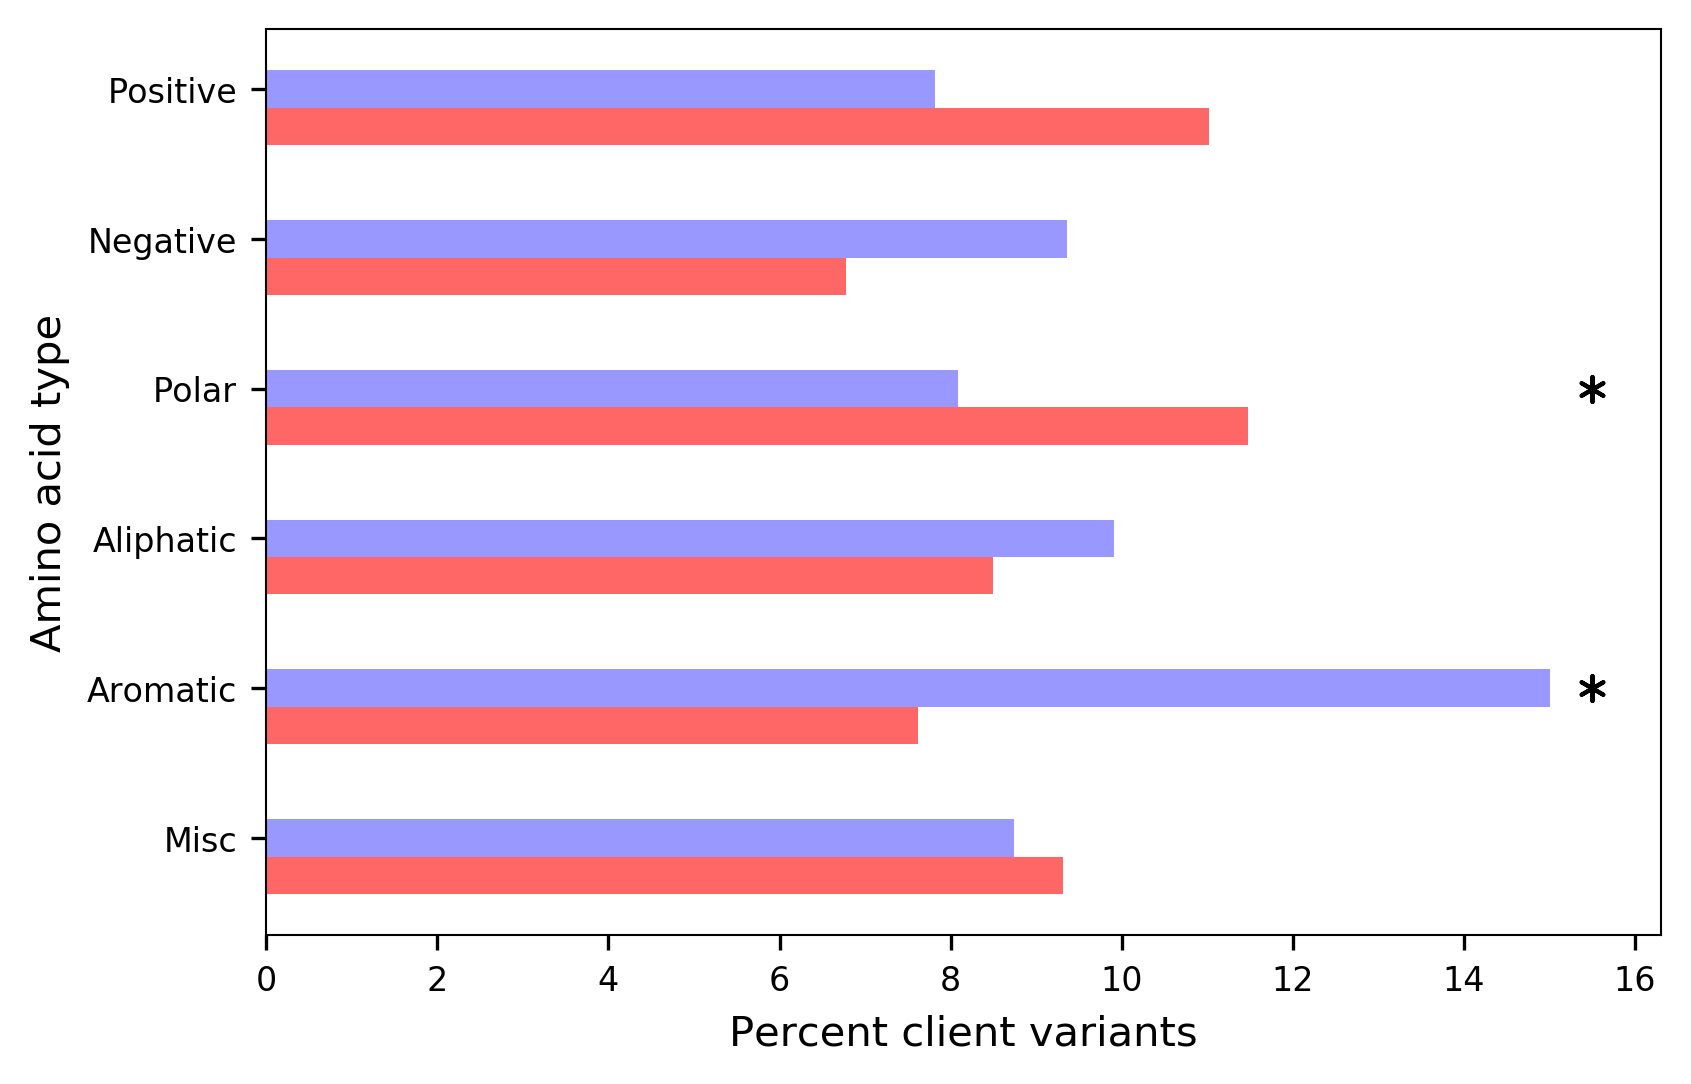

In [165]:
# Plot percent of amino acid mutations that are clients
fig, ax = plt.subplots()
num_muts = agg_mask_map(~np.isnan(resid_map.values))
num_ihb = agg_mask_map(ihb_client_mask)
num_dep = agg_mask_map(dep_client_mask)

perc_dep = 100 * (num_dep / num_muts)
perc_ihb = 100 * (num_ihb / num_muts)

# Set bar width
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(list(agg_dict.keys())))
r2 = [x + barWidth for x in r1]

# Set color
color_bars = []
for val in diff:
    if val > 0:
        color_bars.append(ihb)
    else:
        color_bars.append(dep)

# Plot bars
#fig, ax = plt.subplots()
ax.barh(r1, perc_dep, height=barWidth, color=dep)
ax.barh(r2, perc_ihb, height=barWidth, color=ihb)
#ax.barh(y_pos[:-1], perc_ihb[:-1], left=perc_dep[:-1], color=ihb)
#ax.axvline(0, c='k')
 

# Relabel ticks
ax.set_yticks(np.arange(len(agg_dict)))
ax.set_yticklabels(list(agg_dict.keys()))
ax.invert_yaxis()  # labels read top-to-bottom

#ax.set_xlim([-9, 9])

# Label axes
ax.set_xlabel('Percent client variants')
ax.set_ylabel('Amino acid type')

ax.scatter([15.5] * len(pos), pos, marker=(6, 2, 0), c='k', linewidth=1)

In [166]:
fig.savefig('../../../Figures/manuscript_figs/fig4_drafts/agg_supp.png')